<a href="https://colab.research.google.com/github/ElenaBianchini/ColoringGrayscaleImages/blob/main/Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test

Questo blocco note ha lo scopo di testare il funzionamento della rete preallenata. 

## Import

In [ ]:
%matplotlib inline

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision 
import torchvision.transforms as transforms
import torchvision.transforms.functional as t
import torch.nn as nn
from skimage import color
from PIL import Image
from torchsummary import summary
from google.colab import files
from io import BytesIO

In [ ]:
use_gpu = torch.cuda.is_available()
if use_gpu:
  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")

In [ ]:
device

device(type='cpu')

## Modello 

In [ ]:
class ColorizationRNet(nn.Module):
  def __init__(self, input_size = 128):
    super(ColorizationRNet, self).__init__()

    # Importo ResNet che userò per estrarre le features dalle immagini
    resnet = torchvision.models.resnet18(num_classes=205)
    #resnet = torchvision.models.resnet18()
    # Cambio il primo livello di convoluzione di ResNet per accettare input con un solo canale
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Estraggo le feature dalle immagini
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    # Livelli di deconvoluzione:
    self.deconv = nn.Sequential(
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Upsample(scale_factor=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
        nn.Upsample(scale_factor=2)
    )

  def forward(self, x):
    x = self.midlevel_resnet(x)
    output = self.deconv(x)
    return output

In [ ]:
model = ColorizationRNet()

## Caricamento di un modello preallenato

In [ ]:
!git clone https://github.com/ElenaBianchini/ColoringGrayscaleImages.git

Cloning into 'ColoringGrayscaleImages'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 223 (delta 27), reused 21 (delta 8), pack-reused 168
Receiving objects: 100% (223/223), 22.52 MiB | 10.99 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [ ]:
file_modello = "/content/ColoringGrayscaleImages/test/modello2.pth"

In [ ]:
pretrained = torch.load(file_modello, map_location = torch.device("cpu"))
model.load_state_dict(pretrained)
model = model.to(device)

## Caricare un'immagine

Inserire un'immagine a scelta che sarà:


*   Ridimensionata a 224x244
*   Modificata in bianco e nero 



In [ ]:
uploaded = files.upload()

Saving montagna.jpeg to montagna.jpeg


In [ ]:
img = Image.open(BytesIO(uploaded['''inserire il nome dell'immagine caricata con estensione''']))
# esempio:
#img = Image.open(BytesIO(uploaded["montagna.jpeg"]))
img = np.array(img)
img_gray = color.rgb2gray(img)
img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
img_gray = t.resize(img_gray, (224,224))

img = torch.from_numpy(img.transpose(2,0,1))
img = t.resize(img, (224,224))

x = []
x.append(img_gray)
x = torch.stack(x)
print(x.shape)
print(img.shape)

torch.Size([1, 1, 224, 224])
torch.Size([3, 224, 224])


## Risultato

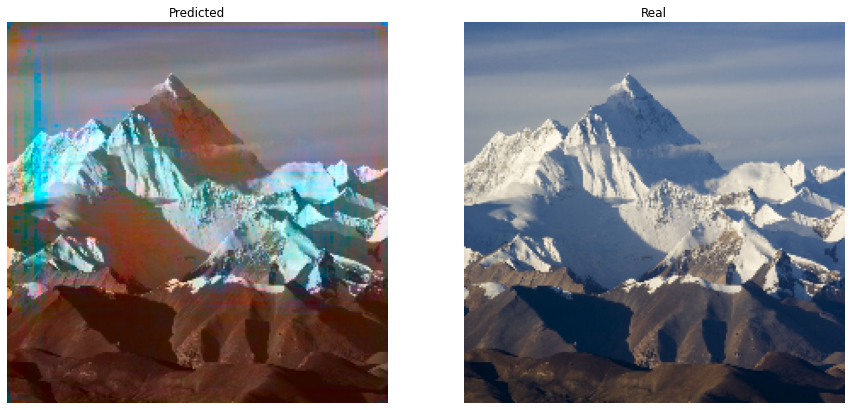

In [ ]:
import warnings
warnings.filterwarnings("ignore") #disabilito i warning per avere una stampa più pulita

with torch.no_grad():
  predicted_ab = model(x)

output = np.zeros((224,224,3))
output[:,:,0]= (img_gray.numpy().reshape((224,224)))*100
output[:,:,1:3] = (predicted_ab[0].numpy().transpose((1,2,0)))*255-128
output = color.lab2rgb(output)

img = img.numpy()

f, ax = plt.subplots(1,2)
f.set_size_inches(15, 15)
ax[0].imshow(output)
ax[1].imshow(img.transpose((1,2,0)))
ax[0].set_title("Predicted")
ax[1].set_title("Real")
ax[0].axis('off'),ax[1].axis('off') 
plt.show()